# Prep

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# View raw file

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
folder_path = '/content/drive/MyDrive/UIT/UIT_Graduation_Thesis/Dataset/0_Raw/28-09-2024/CSI_Packets/session01'

# List all files in the folder
file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
sorted_files = sorted(file_list)
print("Original:",file_list)
print("Sorted:",sorted_files)
dfs = []
for file_name in sorted_files:
    print(file_name)
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    dfs.append(df)
print(len(dfs))

Original: ['5_persons.csv', '4_persons.csv', '3_persons.csv', '2_persons.csv', '1_persons.csv', '0_persons.csv']
Sorted: ['0_persons.csv', '1_persons.csv', '2_persons.csv', '3_persons.csv', '4_persons.csv', '5_persons.csv']
0_persons.csv
1_persons.csv
2_persons.csv
3_persons.csv
4_persons.csv
5_persons.csv
6


In [5]:
print(dfs[0])

           type role                mac  rssi  rate  sig_mode  mcs  bandwidth  \
0      CSI_DATA   AP  B0:A7:32:D7:5B:54   -70    11         0    0          0   
1      CSI_DATA   AP  B0:A7:32:D7:5B:54   -75    11         1    1          1   
2      CSI_DATA   AP  B0:A7:32:D7:5B:54   -71    11         0    0          0   
3      CSI_DATA   AP  B0:A7:32:D7:5B:54   -69    11         0    0          0   
4      CSI_DATA   AP  B0:A7:32:D7:5B:54   -69    11         0    0          0   
...         ...  ...                ...   ...   ...       ...  ...        ...   
17987  CSI_DATA   AP  B0:A7:32:D7:5B:54   -73    11         1    0          1   
17988  CSI_DATA   AP  B0:A7:32:D7:5B:54   -73    11         1    0          1   
17989  CSI_DATA   AP  B0:A7:32:D7:5B:54   -74    11         1    0          1   
17990  CSI_DATA   AP  B0:A7:32:D7:5B:54   -73    11         1    0          1   
17991  CSI_DATA   AP  B0:A7:32:D7:5B:54   -74    11         1    0          1   

       smoothing  not_sound

In [6]:
for x in dfs:
  print(x.shape)

(17992, 27)
(16082, 27)
(15851, 27)
(15676, 27)
(15616, 27)
(13528, 27)


# ESP32 Class

In [7]:
import numpy as np
import pandas as pd
import re

class ESP32:
    """Parse ESP32 Wi-Fi Channel State Information (CSI) obtained using ESP32 CSI Toolkit by Hernandez and Bulut.
    ESP32 CSI Toolkit: https://stevenmhernandez.github.io/ESP32-CSI-Tool/
    """

    # View README.md for more information on null subcarriers
    NULL_SUBCARRIERS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 64, 65, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 382, 383]

    def __init__(self, csi_file):
        self.csi_file = csi_file
        self.__read_file()

    def __read_file(self):
        """Read RAW CSI file (.csv) using Pandas and return a Pandas dataframe
        """
        self.csi_df = pd.read_csv(self.csi_file)

    def seek_file(self):
        """Seek RAW CSI file
        """
        return self.csi_df

    def filter_by_sig_mode(self, sig_mode):
        """Filter CSI data by signal mode
        Args:
            sig_mode (int):
            0 : Non - High Throughput Signals (non-HT)
            1 : HIgh Throughput Signals (HT)
        """
        self.csi_df = self.csi_df.loc[self.csi_df['sig_mode'] == sig_mode]
        return self

    def get_csi(self):
        """Read CSI string as Numpy array

        The CSI data collected by ESP32 contains channel frequency responses (CFR) represented by two signed bytes (imaginary, real) for each sub-carriers index
        The length (bytes) of the CSI sequency depends on the CFR type
        CFR consist of legacy long training field (LLTF), high-throughput LTF (HT-LTF), and space- time block code HT-LTF (STBC-HT-LTF)
        Ref: https://docs.espressif.com/projects/esp-idf/en/latest/esp32/api-guides/wifi.html#wi-fi-channel-state-information

        NOTE: Not all 3 field may not be present (as represented in table and configuration)
        """
        raw_csi_data = self.csi_df['CSI_DATA'].copy()
        csi_data = np.array([np.fromstring(csi_datum.strip('[ ]'), dtype=int, sep = ' ') for csi_datum in raw_csi_data])
        self.csi_data = csi_data
        return self

    # NOTE: Currently does not provide support for all signal subcarrier types
    def remove_null_subcarriers(self):
        """Remove NULL subcarriers from CSI
        """

        # Non-HT Signals (20 Mhz) - non STBC
        if self.csi_data.shape[1] == 128:
            remove_null_subcarriers = self.NULL_SUBCARRIERS[:24]
        # HT Signals (40 Mhz) - non STBC
        elif self.csi_data.shape[1] == 384:
            remove_null_subcarriers = self.NULL_SUBCARRIERS
        else:
            return self

        csi_data_T = self.csi_data.T
        csi_data_T_clean = np.delete(csi_data_T, remove_null_subcarriers, 0)
        csi_data_clean = csi_data_T_clean.T
        self.csi_data = csi_data_clean

        return self

    def get_amplitude_from_csi(self):
        """Calculate the Amplitude (or Magnitude) from CSI
        Ref: https://farside.ph.utexas.edu/teaching/315/Waveshtml/node88.html
        """
        amplitude = np.array([np.sqrt(data[::2]**2 + data[1::2]**2) for data in self.csi_data])
        self.amplitude = amplitude
        return self

    def get_phase_from_csi(self):
        """Calculate the Amplitude (or Magnitude) from CSI
        Ref: https://farside.ph.utexas.edu/teaching/315/Waveshtml/node88.html
        """
        phase = np.array([np.arctan2(data[::2], data[1::2]) for data in self.csi_data])
        self.phase = phase
        return self


# Extract amplitude and filter null columns (64->52)

In [8]:
amp_dfs = []
for file_name in sorted_files:
    file_path = os.path.join(folder_path, file_name)
    csi_array = (
        ESP32(file_path)
             .get_csi()
             .remove_null_subcarriers()
             .get_amplitude_from_csi()
             .get_phase_from_csi()
)
    amp_dfs.append(csi_array.amplitude)
print(len(amp_dfs))



6


In [9]:
for x in amp_dfs:
  print(x.shape)

(17992, 52)
(16082, 52)
(15851, 52)
(15676, 52)
(15616, 52)
(13528, 52)


# Visualization

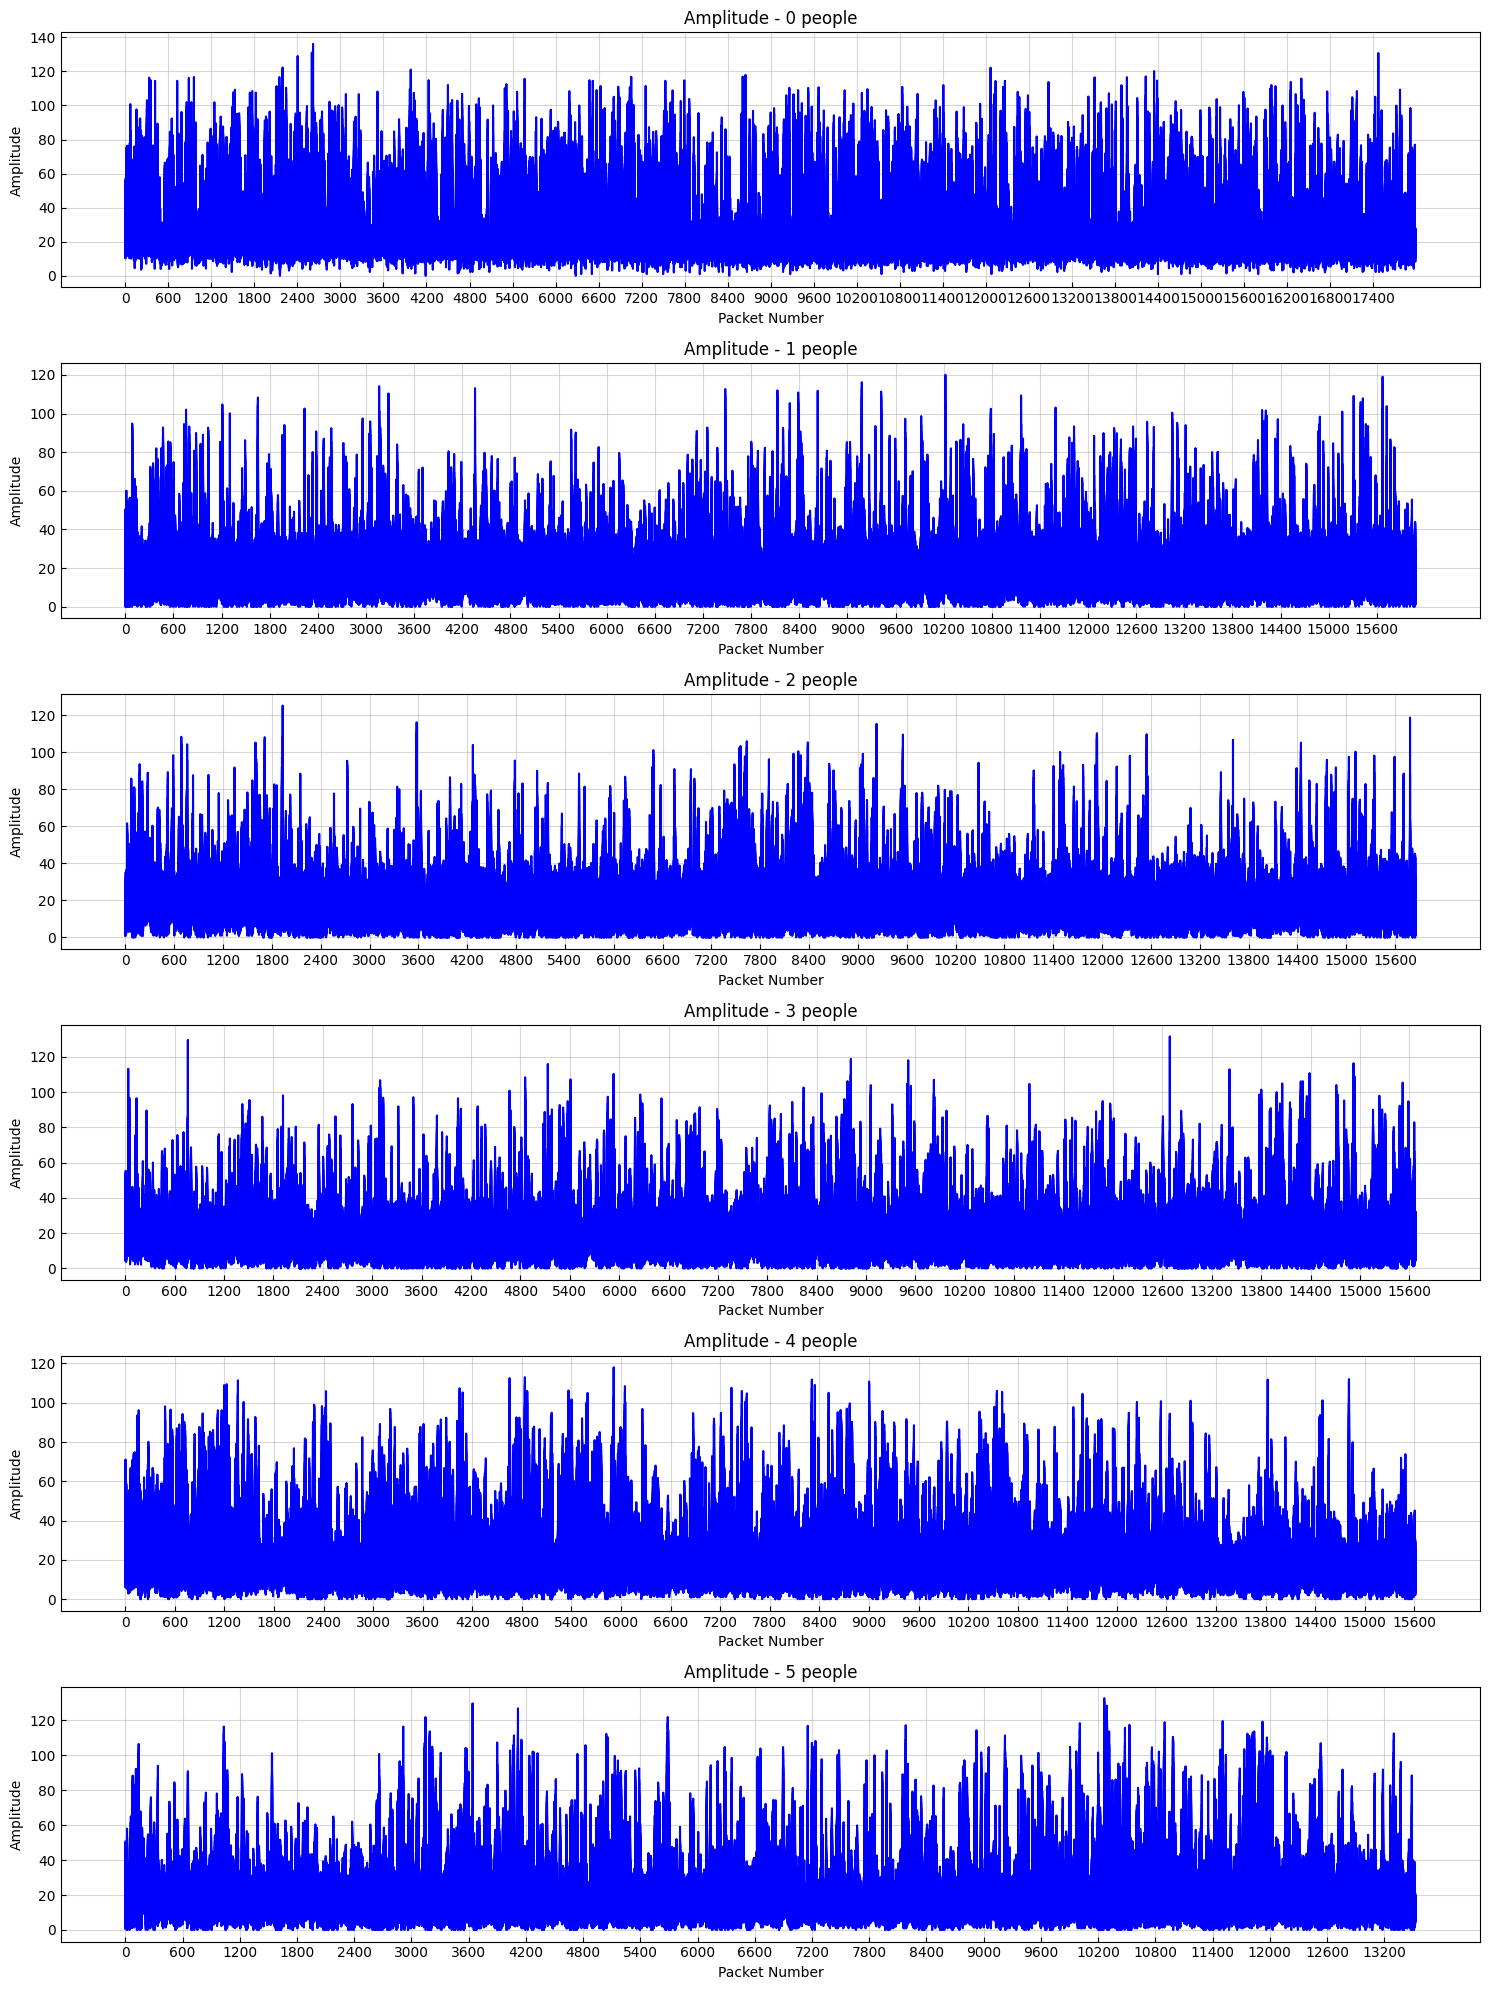

In [10]:
plt.style.use('default')

fig, ax = plt.subplots(len(amp_dfs), 1)
index = 0
for x in amp_dfs:
    amp_x = [i for i in range(amp_dfs[index].shape[0])]
    ax[index].plot(amp_x, amp_dfs[index],color='blue')
    ax[index].set(xlabel='Packet Number', ylabel='Amplitude',
       title=f'Amplitude - {index} people')
    ax[index].grid()
    ax[index].tick_params(direction='in', grid_alpha=0.5)
    ax[index].set_xticks(np.arange(0, len(amp_x)+1, 600))
    index += 1

fig.set_figheight(20)
fig.set_figwidth(15)

plt.tight_layout()
plt.show()


# Export amp

In [11]:
index = 0
for x in amp_dfs:
  df = pd.DataFrame(x, index=None)
  df.to_csv(f"/content/drive/MyDrive/UIT/UIT_Graduation_Thesis/Dataset/1_Processed/CSI_Amplitudes/csi-amp-sess01-{index}.csv",index=False)
  index += 1